### Import libraries

In [117]:
import os
# data processing
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# data science
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [164]:
class DataProcessing:
    """
    Data processing class
    - create dummies
    - scale
    - process (scale, create dummies, split)
    """

    def __init__(self, data: pd.DataFrame, target: str, test_size: float, seed: int):
        self.data = data
        self.target = target
        self.test_size = test_size
        self.seed = seed

    def create_dummies(self, cols: list, drop_first: bool=True) -> pd.DataFrame:
        """
        Create dummy variables from categorical variables
        """
        if not isinstance(cols, list):
            cols = [cols]
        for col in cols:
            data_dummies = pd.get_dummies(self.data[col], prefix=col, drop_first=drop_first).astype(int)
            self.data = pd.concat([self.data, data_dummies], axis=1)
        self.data = self.data.drop(cols, axis=1)
        return self.data


    def split(self, data: pd.DataFrame):
        """
        Split data into train and test
        """
        data_train, data_test = train_test_split(
            data, test_size=self.test_size, random_state=self.seed
        )
        return data_train, data_test
    
    def scale_split(self, cols: list) -> pd.DataFrame:
        """
        Scale ordinal variables
        """
        if not isinstance(cols, list):
            cols = [cols]
        # standardizer
        scaler = StandardScaler()
        scaler.set_output(transform="pandas")
        # split
        data_train, data_test = self.split(self.data)
        # fit and transform
        for col in cols:
            data_train[col] = scaler.fit_transform(data_train[[col]])
            data_test[col] = scaler.transform(data_test[[col]])
        self.data = pd.concat([data_train, data_test], axis=0)
        return self.data

    def process(self, col_card: list, col_ord: list):
        """
        Process data
        """
        # scale
        self.scale_split(cols=col_ord)
        # create dummies
        self.create_dummies(cols=col_card)
        # split
        X_train, X_test = self.split(self.data.drop(self.target, axis=1))

        y_train, y_test = self.split(self.data[[self.target]])

        return X_train, X_test, y_train, y_test

In [165]:
def selection_by_corr(dataset, threshold):
    corr_ = (dataset.corr() * -(np.identity(dataset.shape[1]) - 1)).abs()
    while corr_.max().max() > threshold:
        args = np.unravel_index(corr_.to_numpy().argmax(), corr_.shape)
        if corr_.iloc[args[0], :].mean() > corr_.iloc[:, args[1]].mean():
            name_drop = corr_.iloc[args[0], :].name
            corr_.drop(name_drop, axis=1, inplace=True)
            corr_.drop(name_drop, axis=0, inplace=True)
        else:
            name_drop = corr_.iloc[:, args[1]].name
            corr_.drop(name_drop, axis=1, inplace=True)
            corr_.drop(name_drop, axis=0, inplace=True)
    return corr_.columns.values

In [166]:
[i for i in os.listdir("data") if i.endswith(".data")]

['processed_cleveland.data']

### Variables

In [167]:
path = "data/processed_cleveland.data"
seed = 42
split_size = 0.3

## Análisis

### Import data

In [168]:
names = [
    'age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang',
    'oldpeak','slope','ca','thal','num'
]

In [169]:
data = pd.read_csv(path, header=None)
data.columns = names

In [170]:
data.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
291,55.0,0.0,2.0,132.0,342.0,0.0,0.0,166.0,0.0,1.2,1.0,0.0,3.0,0
141,59.0,1.0,1.0,170.0,288.0,0.0,2.0,159.0,0.0,0.2,2.0,0.0,7.0,1
281,47.0,1.0,3.0,130.0,253.0,0.0,0.0,179.0,0.0,0.0,1.0,0.0,3.0,0
260,44.0,0.0,3.0,118.0,242.0,0.0,0.0,149.0,0.0,0.3,2.0,1.0,3.0,0
245,67.0,1.0,4.0,120.0,237.0,0.0,0.0,71.0,0.0,1.0,2.0,0.0,3.0,2


In [171]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


### Format processing

In [172]:
data[data[data == "?"].notnull().any(axis=1)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


Existen datos en ca y thal que son ?. 

Estas entradas representan 6/303 = 0.019 -> 1.9%

Se removeran estas entradas

In [173]:
data = (
    data
    .query("ca != '?' and thal != '?'")
    .assign(
        ca = lambda k: k.ca.astype(float),
        thal = lambda k: k.thal.astype(float),
        num = lambda k: np.where(k.num > 0, 1, 0)
    )
)

In [174]:
data = (
    data
    .assign(
        sex = lambda k: k.sex.astype("category"),
        cp = lambda k: k.cp.astype("category"),
        exang = lambda k: k.exang.astype("category"),
        slope = lambda k: k.slope.astype("category"),
        thal = lambda k: k.thal.astype("category")
    )
)

In [175]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("num", axis=1), data[["num"]], test_size=split_size, random_state=seed
)

In [176]:
# categorical variables
X_train_cat = X_train.select_dtypes(include="category")
# ordinal variables
X_train_ord = X_train.select_dtypes(include=np.number)

### Calculate correlation

In [177]:
# correlation spearman
X_train_cat.corr(method="spearman").abs().style.background_gradient(cmap="coolwarm")

,sex,cp,exang,slope,thal
sex,1.000000,0.078621,0.190396,0.029293,0.397816
cp,0.078621,1.000000,0.438351,0.151966,0.294815
exang,0.190396,0.438351,1.000000,0.214334,0.303364
slope,0.029293,0.151966,0.214334,1.000000,0.181306
thal,0.397816,0.294815,0.303364,0.181306,1.000000


In [178]:
# correlation pearson
X_train_ord.corr(method="pearson").abs().style.background_gradient(cmap="coolwarm")

,age,trestbps,chol,fbs,restecg,thalach,oldpeak,ca
age,1.000000,0.242166,0.187714,0.162945,0.103325,0.407587,0.205622,0.301078
trestbps,0.242166,1.000000,0.090187,0.199315,0.122061,0.010049,0.077950,0.055723
chol,0.187714,0.090187,1.000000,0.030658,0.135911,0.031801,0.054819,0.132022
fbs,0.162945,0.199315,0.030658,1.000000,0.079521,0.015820,0.038117,0.184629
restecg,0.103325,0.122061,0.135911,0.079521,1.000000,0.005288,0.038169,0.123223
thalach,0.407587,0.010049,0.031801,0.015820,0.005288,1.000000,0.367592,0.259173
oldpeak,0.205622,0.077950,0.054819,0.038117,0.038169,0.367592,1.000000,0.282241
ca,0.301078,0.055723,0.132022,0.184629,0.123223,0.259173,0.282241,1.000000


In [179]:
# No existe una correlacion alta entre los datos

## Modelos lineales

In [180]:
col_card = ["cp", "slope", "thal"]
col_ord = ['age', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'oldpeak', 'ca']

In [181]:
X_train, X_test, y_train, y_test = (
    DataProcessing(data = data, target = "num", test_size = split_size, seed = seed)
    .process(col_card, col_ord)
)

### Regresion Logistica

In [145]:
data.num.value_counts()

num
0    160
1    137
Name: count, dtype: int64

In [115]:
model = LogisticRegression(max_iter=1_000).fit(X_train, y_train.values.reshape(-1))

print("Regresion logistica")

print(f"Accuracy-Train: {model.score(X_train, y_train):.4f}")

print(f"Accuracy-Test: {model.score(X_test, y_test):.4f}")

Regresion logistica
Accuracy-Train: 0.8744
Accuracy-Test: 0.8222


In [116]:
confusion_matrix(y_test, model.predict(X_test))

array([[40,  8],
       [ 8, 34]], dtype=int64)

### R.L. con seleccion de variables

In [213]:
data_names = X_train.pipe(selection_by_corr, threshold=0.4)
X_train_select = X_train[data_names]
X_test_select = X_test[data_names]

In [218]:
data_names

array(['age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'exang',
       'oldpeak', 'ca', 'cp_2.0', 'cp_3.0', 'slope_2.0', 'slope_3.0',
       'thal_6.0'], dtype=object)

In [215]:
model = LogisticRegression(max_iter=1_000).fit(X_train_select, y_train.values.reshape(-1))

print("Regresion logistica con variables seleccionadas")

print(f"Accuracy-Train: {model.score(X_train_select, y_train):.4f}")

print(f"Accuracy-Test: {model.score(X_test_select, y_test):.4f}")

Regresion logistica con variables seleccionadas
Accuracy-Train: 0.8599
Accuracy-Test: 0.7889


In [216]:
confusion_matrix(y_test, model.predict(X_test_select))

array([[39,  9],
       [10, 32]], dtype=int64)

### R.L. con PCA

Text(0, 0.5, 'cumulative explained variance')

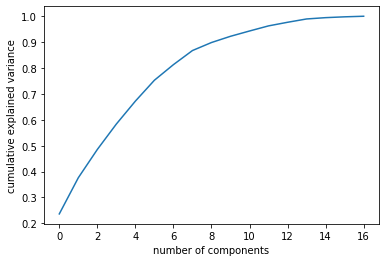

In [61]:
# plot a cumulative explained variance plot
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")

# debido a la estandarizacion de los datos, no se observa un 
# cambio significativo en la varianza explicada por cada componente

In [227]:
pca = PCA(n_components=3).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [228]:
model = LogisticRegression(max_iter=1_000).fit(X_train_pca, y_train.values.reshape(-1))

print("Regresion logistica con variables seleccionadas de PCA")

print(f"Accuracy-Train: {model.score(X_train_pca, y_train):.4f}")

print(f"Accuracy-Test: {model.score(X_test_pca, y_test):.4f}")

Regresion logistica con variables seleccionadas de PCA
Accuracy-Train: 0.8068
Accuracy-Test: 0.7222


In [83]:
confusion_matrix(y_test, model.predict(X_test_pca))

array([[41,  7],
       [13, 29]], dtype=int64)

### R.L. con LDA

In [107]:
lda = LDA(store_covariance=True).fit(X_train, y_train.values.reshape(-1))

X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

In [110]:
model = LogisticRegression(max_iter=1_000).fit(X_train_lda, y_train.values.reshape(-1))

print("Regresion logistica con variables seleccionadas de LDA")

print(f"Accuracy-Train: {model.score(X_train_lda, y_train):.4f}")

print(f"Accuracy-Test: {model.score(X_test_lda, y_test):.4f}")

Regresion logistica con variables seleccionadas de LDA
Accuracy-Train: 0.8696
Accuracy-Test: 0.7889


In [111]:
confusion_matrix(y_test, model.predict(X_test_lda))

array([[37, 11],
       [ 8, 34]], dtype=int64)